<a href="https://colab.research.google.com/github/rubygitflow/Sequence-to-Sequence-training-models/blob/master/University_of_Artificial_Intelligence_NLP_HomeWork_8_Pro_Attention_mechanism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP.Lesson 8.Attention mechanism

1. Attention: Sequence 2 Sequence model with Attention Mechanism. https://towardsdatascience.com/sequence-2-sequence-model-with-attention-mechanism-9e9ca2a613a
2. Визуализируя нейронный машинный перевод (seq2seq модели с механизмом внимания). https://habr.com/ru/post/486158/

Parallel text corpora En-Ru:
*   http://www.wordsbase.com/2016/01/tm-share.html
*   http://ufal.mff.cuni.cz/umc/cer/
*   https://tatoeba.org/



In [ ]:
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, GlobalMaxPooling1D, LSTM, GRU, Bidirectional, Embedding, Input, Concatenate, Attention, Reshape, Lambda, concatenate, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Accuracy

import tensorflow.keras.backend as K
from keras.regularizers import l2, l1

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

## Checking the GPU

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import os
import psutil
import humanize
import GPUtil as GPU
GPUs = GPU.getGPUs()
if len(GPUs)>0:
  gpu = GPUs[0]
else:
  print('GPU turned off')
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM FREE: "+humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  if len(GPUs)>0:
    print("Gen RAM FREE: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
    print("GPU Model: " + gpu.name)

printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=4b7381f5071c25c5dd52616f1ee5fa40ba2a9f3ba507790f43163e907965b46b
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM FREE: 26.3 GB  | Proc size: 365.1 MB
Gen RAM FREE: 16280MB | Used: 0MB | Util   0% | Total 16280MB
GPU Model: Tesla P100-PCIE-16GB


## Data Setting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def highlight_chars(txt):
  # select spetial  chars
  angle_brackets = ['<', '>']
  for elem in angle_brackets:
    txt = txt.replace(elem, ' '+elem+' ')

  # select digits
  txt = re.sub(r'\d\d\.\d\d\.\d{4}', r' <date> ', txt)  # "" 
  txt = re.sub(r'\d\d\.\d\d\.\d\d', r' <date> ', txt)   # "" 
  txt = re.sub(r'\d\d\/\d\d\/\d{4}', r' <date> ', txt)  # "" 
  txt = re.sub(r'\d\d\/\d\d\/\d\d', r' <date> ', txt)   # "" 
  txt = re.sub(r'\d\d:\d\d:\d\d', r' <time> ', txt)     # "" 
  txt = re.sub(r'\d\d-\d\d-\d\d', r' <time> ', txt)     # "" 
  txt = re.sub(r'\d\d—\d\d—\d\d', r' <time> ', txt)     # "" 
  txt = re.sub(r'\d\d–\d\d–\d\d', r' <time> ', txt)     # "" 
  txt = re.sub(r'\d\d:\d\d', r'<time>', txt)          # "" 

  txt = re.sub(r'\d+-\d+', r' <range> ', txt)         #  '4-5'
  txt = re.sub(r'\d+\/\d+', r' <real> ', txt)         # "8/8" 
  txt = re.sub(r'\d+,\d+', r' <real> ', txt)          # "8,8" 
  txt = re.sub(r'\d+\.\d+', r' <number> ', txt)       # "9.8" 
  # for \s-char exclude \t-char
  txt = re.sub(r'-\d+\. ', r' <number> . ', txt)     # "-1. "  
  txt = re.sub(r'–\d+\. ', r' <number> . ', txt)     # "–1. "  
  txt = re.sub(r'—\d+\. ', r' <number> . ', txt)     # "—1. "  
  txt = re.sub(r'\d+\.\n', r' <number> . ', txt)      # "7. "  
  txt = re.sub(r'-\d+\.\n', r' <number> . ', txt)     # "-1. "  
  txt = re.sub(r'–\d+\.\n', r' <number> . ', txt)     # "–1. "  
  txt = re.sub(r'—\d+\.\n', r' <number> . ', txt)     # "—1. "  
  txt = re.sub(r'\d+\.\n', r' <number> . ', txt)      # "7. "  

  txt = re.sub(r'\d+', r' <number> ', txt)      # "17"  

  # select any symbols (manually created list)
  char_list = ['-', '.', ',', '"', '$', '«', 'ø', '%', ')', '&', '−', '≤', '‘', '£', '?', '™', '‚', '(', '*', '№', '•', ';', '½', '’', '/', '+', '±', '>', '“', 'ş', '¦', '–', "'", '€', '#', '§', '”', '@', '‑', ':', '!', '»', '¼', '·', '°', '…', '=', '—']
  refreshed_char_list = [item for item in char_list if item not in angle_brackets]  # very important exclude spetial  chars from list !
  for elem in refreshed_char_list:
    txt = txt.replace(elem, ' '+elem+' ')
    
  return txt

**Here we carry out chars-cleaning iterations**

In [ ]:
with open('/content/drive/My Drive/Базы/NLP/English-Russian.1-1.txt', 'r') as f:
  text = f.read()
  text = text.replace('\ufeff', '')  
  text = text.replace('\uf043', ' ')  
  text = text.replace('\x9d', ' ')  
  text = text.replace('\uf029', ' ')  
  text = text.replace('\x81', ' ')  
  text = text.replace('\xad', ' ')  
  text = text.replace('\uf024', ' ')  
  text = text.replace('\x91', ' ')  
  text = text.replace('\uf042', ' ')  
  text = text.replace('\x8d', ' ')  
  text = text.replace('\x80', ' ')  
  text = text.replace('\uf0d4', ' ')  
  text = text.replace('\x90', ' ')  
  text = text.replace('\x8f', ' ')  
  text = text.replace('\uf0b7', ' ')  
  text = text.replace('�', ' ')  
  text = text.replace('', ' ')
  text = highlight_chars(text)

  text_of_chars = re.sub(r'[А-яA-z0-9\n\t<>]', ' ', text) 
  text_of_chars = ' '.join(text_of_chars.split())

In [ ]:
chars = list(set(text_of_chars.lower().split(' ')))
len(chars)

84

In [ ]:
chars

['ё',
 'â',
 '?',
 '"',
 'ń',
 'áš',
 '.',
 '±',
 'ёё',
 'ű',
 ';',
 '(',
 '/',
 'õ',
 'ë',
 '«',
 ')',
 '!',
 'ŕ',
 'č',
 '=',
 '‘',
 ',',
 'ä',
 'î',
 'š',
 '‑',
 '≤',
 '£',
 '·',
 'ï',
 'ç',
 'á',
 '‚',
 '-',
 '@',
 ':',
 'ğ',
 '“',
 'ú',
 'β',
 'è',
 '*',
 '#',
 '¦',
 'ć',
 '’',
 '¼',
 'ö',
 '+',
 'ó',
 'í',
 '—',
 'é',
 'ł',
 'ñ',
 'ø',
 '°',
 'łę',
 'ô',
 '»',
 '–',
 '™',
 '−',
 '…',
 '½',
 '№',
 'ş',
 'ří',
 'à',
 '•',
 'ό',
 'å',
 '”',
 'ґ',
 '&',
 "'",
 '$',
 '%',
 '§',
 '€',
 'ã',
 'ê',
 'ü']

In [ ]:
num_chars = 100 # get all the symbols — http://book.itep.ru/10/ascii.htm
tokenizer = Tokenizer(num_words=num_chars, char_level=True) 
tokenizer.fit_on_texts(chars)
tokenizer.index_word

{1: 'ё',
 2: 'á',
 3: 'š',
 4: 'í',
 5: 'ł',
 6: 'â',
 7: '?',
 8: '"',
 9: 'ń',
 10: '.',
 11: '±',
 12: 'ű',
 13: ';',
 14: '(',
 15: '/',
 16: 'õ',
 17: 'ë',
 18: '«',
 19: ')',
 20: '!',
 21: 'ŕ',
 22: 'č',
 23: '=',
 24: '‘',
 25: ',',
 26: 'ä',
 27: 'î',
 28: '‑',
 29: '≤',
 30: '£',
 31: '·',
 32: 'ï',
 33: 'ç',
 34: '‚',
 35: '-',
 36: '@',
 37: ':',
 38: 'ğ',
 39: '“',
 40: 'ú',
 41: 'β',
 42: 'è',
 43: '*',
 44: '#',
 45: '¦',
 46: 'ć',
 47: '’',
 48: '¼',
 49: 'ö',
 50: '+',
 51: 'ó',
 52: '—',
 53: 'é',
 54: 'ñ',
 55: 'ø',
 56: '°',
 57: 'ę',
 58: 'ô',
 59: '»',
 60: '–',
 61: '™',
 62: '−',
 63: '…',
 64: '½',
 65: '№',
 66: 'ş',
 67: 'ř',
 68: 'à',
 69: '•',
 70: 'ό',
 71: 'å',
 72: '”',
 73: 'ґ',
 74: '&',
 75: "'",
 76: '$',
 77: '%',
 78: '§',
 79: '€',
 80: 'ã',
 81: 'ê',
 82: 'ü'}

In [ ]:
char_list = tokenizer.index_word.values()

In [ ]:
char_list

dict_values(['ё', 'á', 'š', 'í', 'ł', 'â', '?', '"', 'ń', '.', '±', 'ű', ';', '(', '/', 'õ', 'ë', '«', ')', '!', 'ŕ', 'č', '=', '‘', ',', 'ä', 'î', '‑', '≤', '£', '·', 'ï', 'ç', '‚', '-', '@', ':', 'ğ', '“', 'ú', 'β', 'è', '*', '#', '¦', 'ć', '’', '¼', 'ö', '+', 'ó', '—', 'é', 'ñ', 'ø', '°', 'ę', 'ô', '»', '–', '™', '−', '…', '½', '№', 'ş', 'ř', 'à', '•', 'ό', 'å', '”', 'ґ', '&', "'", '$', '%', '§', '€', 'ã', 'ê', 'ü'])

**End of chars-cleaning iterations**

In [ ]:
text_of_lexemes = ' '.join(text.split(' '))

In [ ]:
print(text_of_lexemes[:1000])

Musharraf  ’  s Last Act  ? 	Последний ход Мушаррафа  ? 
Desperate to hold onto power  ,  Pervez Musharraf has discarded Pakistan  ’  s constitutional framework and declared a state of emergency  . 	В отчаянном стремлении удержать власть  ,  Первез Мушарраф отверг конституционную систему Пакистана и объявил о введении чрезвычайного положения  . 
Artfully  ,  though shamelessly  ,  he has tried to sell this action as an effort to bring about stability and help fight the war on terror more effectively  . 	Искусно  ,  хотя и бессовестно  ,  он попытался оправдать данное действие стремлением установить стабильность и начать более эффективную борьбу с терроризмом  . 
Nothing could be further from the truth  . 	Это крайне далеко от действительности  . 
If Pakistan  ’  s history is any indicator  ,  his decision to impose martial law may prove to be the proverbial straw that breaks the camel  ’  s back  . 	Если судить по пакистанской истории  ,  его решение установить военное положение может 

In [ ]:
dictionary = text_of_lexemes.split('\n')

In [ ]:
dictionary.__len__()

85960

In [ ]:
en = []
ru = [] 
# provide a protection from obvious garbage
for elem in dictionary:
  dic = elem.split('\t')
  eng = ' '.join(dic[0].split())
  rus = ' '.join(dic[1].split())
  # count of words
  len_en = len(eng.split())
  len_ru = len(rus.split()) 
  if len_en > 4 and len_ru > 4: # this condition was added after learning
    if len_en > len_ru // 2 and len_ru > len_en // 2: #  we consider only meaningful constructions
      if re.search(r'[A-z]+', eng) and re.search(r'[А-я]+', rus): #  we have a real translation
        en.append(eng)
        ru.append(rus)

In [ ]:
len(en), len(ru)

(81739, 81739)

In [ ]:
ru[:13], en[:13]

(['Последний ход Мушаррафа ?',
  'В отчаянном стремлении удержать власть , Первез Мушарраф отверг конституционную систему Пакистана и объявил о введении чрезвычайного положения .',
  'Искусно , хотя и бессовестно , он попытался оправдать данное действие стремлением установить стабильность и начать более эффективную борьбу с терроризмом .',
  'Это крайне далеко от действительности .',
  'Если судить по пакистанской истории , его решение установить военное положение может оказаться той самой последней каплей из пословицы , которая переполнит чашу терпения народа .',
  'Генерал Мушарраф появился на национальной сцене Пакистана <number> октября <number> года , свергнув законно избранное правительство и объявив о начале амбициозного проекта по « строительству нации » .',
  'Многие пакистанцы , лишённые иллюзий в отношении политического класса Пакистана , молчаливо согласились с его приходом к власти , думая , что он сможет что - то изменить .',
  'Террористические атаки в Америке <number> с

In [ ]:
ru[:85000]

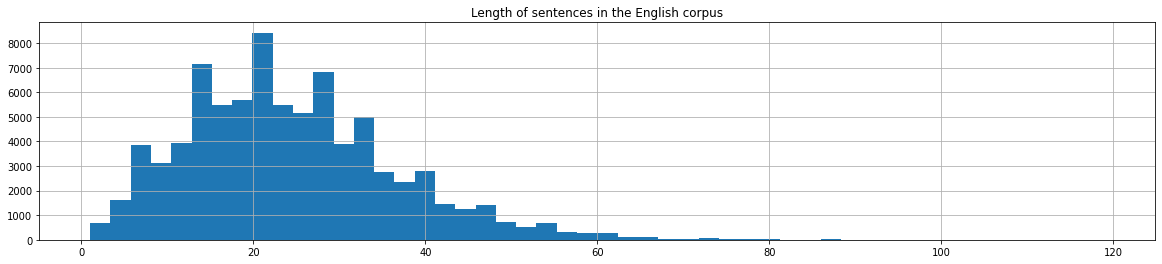

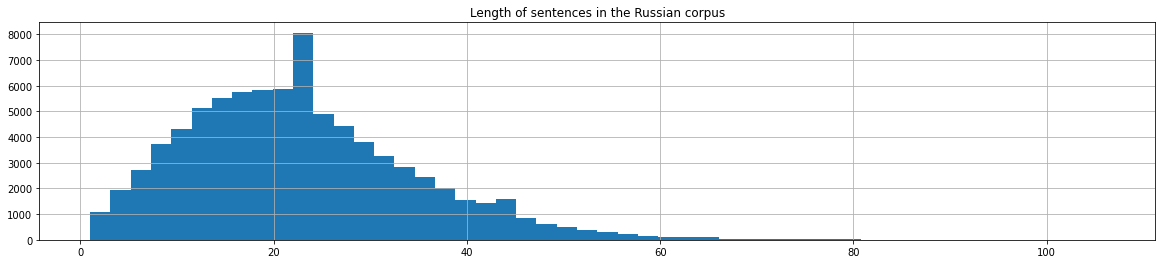

In [ ]:
# Let's see which sentence length to choose
sizeEn = []
for i in en:
  sizeEn.append(len(i.split()))
plt.figure(figsize=(20,4))
plt.title('Length of sentences in the English corpus')
plt.hist(sizeEn, bins=50)
plt.grid(True)
plt.show()

sizeRu = []
for i in ru:
  sizeRu.append(len(i.split()))
plt.figure(figsize=(20,4))
plt.title('Length of sentences in the Russian corpus')
plt.hist(sizeRu, bins=50)
plt.grid(True)
plt.show()


In [ ]:
min(sizeRu), max(sizeRu), len(sizeRu)

(1, 106, 81739)

In [ ]:
min(sizeEn), max(sizeEn), len(sizeEn)

(1, 119, 81739)

In [ ]:
enc_in = [q + ' <END>' for q in ru]

In [ ]:
enc_in[:13]

['Последний ход Мушаррафа ? <END>',
 'В отчаянном стремлении удержать власть , Первез Мушарраф отверг конституционную систему Пакистана и объявил о введении чрезвычайного положения . <END>',
 'Искусно , хотя и бессовестно , он попытался оправдать данное действие стремлением установить стабильность и начать более эффективную борьбу с терроризмом . <END>',
 'Это крайне далеко от действительности . <END>',
 'Если судить по пакистанской истории , его решение установить военное положение может оказаться той самой последней каплей из пословицы , которая переполнит чашу терпения народа . <END>',
 'Генерал Мушарраф появился на национальной сцене Пакистана <number> октября <number> года , свергнув законно избранное правительство и объявив о начале амбициозного проекта по « строительству нации » . <END>',
 'Многие пакистанцы , лишённые иллюзий в отношении политического класса Пакистана , молчаливо согласились с его приходом к власти , думая , что он сможет что - то изменить . <END>',
 'Террорист

In [ ]:
decoder_in = ['<START> ' + a for a in en]
decoder_out = [a + ' <END>' for a in en]

In [ ]:
decoder_in[:13]

['<START> Musharraf ’ s Last Act ?',
 '<START> Desperate to hold onto power , Pervez Musharraf has discarded Pakistan ’ s constitutional framework and declared a state of emergency .',
 '<START> Artfully , though shamelessly , he has tried to sell this action as an effort to bring about stability and help fight the war on terror more effectively .',
 '<START> Nothing could be further from the truth .',
 '<START> If Pakistan ’ s history is any indicator , his decision to impose martial law may prove to be the proverbial straw that breaks the camel ’ s back .',
 '<START> General Musharraf appeared on the national scene on October <number> , <number> , when he ousted an elected government and announced an ambitious “ nation - building ” project .',
 '<START> Many Pakistanis , disillusioned with Pakistan ’ s political class , remained mute , thinking that he might deliver .',
 '<START> The September <number> , <number> , terrorist attacks on America brought Musharraf into the international

In [ ]:
decoder_out[:13]

['Musharraf ’ s Last Act ? <END>',
 'Desperate to hold onto power , Pervez Musharraf has discarded Pakistan ’ s constitutional framework and declared a state of emergency . <END>',
 'Artfully , though shamelessly , he has tried to sell this action as an effort to bring about stability and help fight the war on terror more effectively . <END>',
 'Nothing could be further from the truth . <END>',
 'If Pakistan ’ s history is any indicator , his decision to impose martial law may prove to be the proverbial straw that breaks the camel ’ s back . <END>',
 'General Musharraf appeared on the national scene on October <number> , <number> , when he ousted an elected government and announced an ambitious “ nation - building ” project . <END>',
 'Many Pakistanis , disillusioned with Pakistan ’ s political class , remained mute , thinking that he might deliver . <END>',
 'The September <number> , <number> , terrorist attacks on America brought Musharraf into the international limelight as he agree

In [ ]:
num_words = 90000 # cut off only a third of the total volume of terms
tokenizer = Tokenizer(num_words, filters='', oov_token='<UNK>') # it's important to include the "filters" param

In [ ]:
tokenizer.fit_on_texts(enc_in)
tokenizer.fit_on_texts(decoder_in)
tokenizer.fit_on_texts(decoder_out)

In [ ]:
len(tokenizer.index_word)

131415

In [ ]:
tokenizer.index_word

{1: '<UNK>',
 2: ',',
 3: '.',
 4: 'the',
 5: '<end>',
 6: 'of',
 7: 'to',
 8: 'and',
 9: '<start>',
 10: 'in',
 11: 'a',
 12: '-',
 13: 'в',
 14: 'is',
 15: 'и',
 16: 'that',
 17: '<number>',
 18: 's',
 19: 'for',
 20: '’',
 21: 'as',
 22: 'it',
 23: 'be',
 24: 'на',
 25: 'are',
 26: 'but',
 27: 'not',
 28: 'with',
 29: 'не',
 30: 'что',
 31: 'on',
 32: 'by',
 33: "'",
 34: 'this',
 35: '–',
 36: 'have',
 37: 'will',
 38: 'has',
 39: 'с',
 40: '"',
 41: 'from',
 42: 'their',
 43: 'at',
 44: 'its',
 45: 'they',
 46: 'an',
 47: 'was',
 48: 'more',
 49: 'or',
 50: 'как',
 51: ':',
 52: '(',
 53: ')',
 54: 'к',
 55: 'us',
 56: 'world',
 57: 'для',
 58: 'по',
 59: 'countries',
 60: 'но',
 61: 'would',
 62: 'than',
 63: 'can',
 64: 'which',
 65: 'if',
 66: 'all',
 67: 'это',
 68: 'one',
 69: 'we',
 70: 'so',
 71: '”',
 72: '“',
 73: 'europe',
 74: '%',
 75: 'new',
 76: 'only',
 77: 'no',
 78: 'his',
 79: 'political',
 80: 'economic',
 81: 'то',
 82: '?',
 83: 'been',
 84: ';',
 85: 'there',

In [ ]:
X_enc = tokenizer.texts_to_sequences(enc_in)

In [ ]:
len(X_enc)

81739

In [ ]:
X_dec = tokenizer.texts_to_sequences(decoder_in)
Y = tokenizer.texts_to_sequences(decoder_out)

In [ ]:
len(X_dec)

81739

In [ ]:
len(Y)

81739

In [ ]:
# Finding short sentences in the encoder
threshold = 70
idx_q = [len(y) < threshold for y in X_enc]
sum(idx_q)

81576

In [ ]:
X_enc = np.array(X_enc)[idx_q]
X_dec = np.array(X_dec)[idx_q]
Y = np.array(Y)[idx_q]

In [ ]:
X_enc.shape, X_dec.shape, Y.shape

((81576,), (81576,), (81576,))

In [ ]:
# Finding short sentences in the decoder
idx_a = [len(y) < threshold for y in X_dec]
sum(idx_a)

81418

In [ ]:
X_enc = X_enc[idx_a]
X_dec = X_dec[idx_a]
Y = Y[idx_a]

In [ ]:
X_enc.shape, X_dec.shape, Y.shape

((81418,), (81418,), (81418,))

In [ ]:
max_q_len = max([len(el) for el in X_enc]); max_q_len

69

In [ ]:
max_a_len = max([len(el) for el in X_dec]); max_a_len

69

In [ ]:
X_enc = pad_sequences(X_enc, max_q_len, padding='post', truncating='post')
X_dec = pad_sequences(X_dec, max_a_len, padding='post', truncating='post')
Y = pad_sequences(Y, max_a_len, padding='post', truncating='post')

In [ ]:
print(X_enc.shape)
print(X_dec.shape)
print(Y.shape)

(81418, 69)
(81418, 69)
(81418, 69)


In [ ]:
X_enc[5:10]

array([[ 8746,  8993, 10513,    24,  2508, 18728,  5279,    17, 10167,
           17,   247,     2, 62468, 24641, 20624,   446,    15, 20136,
          117,  1907, 41944,  4727,    58,   106, 22463,  4065,   107,
            3,     5,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [  417, 54474,     2, 87353, 22464,    13,   633,  1778,  5618,
         5279,     2, 41945,  9886,    39,   133, 19156,    54,   469,
            2, 31379,     2,    30,   168,  1703,    30,    12,    81,
         2785,     3,     5,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     

In [ ]:
X_dec[5:10]

array([[    9,   486,  2512,  2751,    31,     4,   197,  5044,    31,
         2327,    17,     2,    17,     2,    88,   103, 13079,    46,
         1218,    98,     8,  2307,    46,  3822,    72,   821,    12,
         1088,    71,   839,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [    9,   109, 19554,     2, 21141,    28,   978,    20,    18,
           79,  1366,     2,  2027, 33033,     2,  1329,    16,   103,
          285,  2230,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     

In [ ]:
Y[5:10]

array([[  486,  2512,  2751,    31,     4,   197,  5044,    31,  2327,
           17,     2,    17,     2,    88,   103, 13079,    46,  1218,
           98,     8,  2307,    46,  3822,    72,   821,    12,  1088,
           71,   839,     3,     5,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [  109, 19554,     2, 21141,    28,   978,    20,    18,    79,
         1366,     2,  2027, 33033,     2,  1329,    16,   103,   285,
         2230,     3,     5,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     

# Modelling function

In [ ]:
def decode_sequence(inp_str): 
  """
  Displays the generated answer to the question.
  Passing a string to the function
  Returning a string from the function
  """
  inp_str = inp_str + ' <end>'
  example = pad_sequences(tokenizer.texts_to_sequences([inp_str]), maxlen=max_q_len, padding='post')

  # returning the state [h, c]
  states_value, attention = encoder_model.predict(example)

  # creating an array of length pad+1
  target_token = np.zeros((1,1))
  # assigning the value "start" to the first word
  target_token[0,0] = tokenizer.word_index['<start>']

  # stop flag
  Flag = False
  # reset the sentence
  decoded_sentence = ''

  while not Flag:
    pred, *states_value = decoder_model.predict([attention, target_token] + states_value)
    
    # translating the decoded token into a word 
    token_pred = np.argmax(pred, axis=-1) #
    #print(token_pred)
    
    sampled_word = tokenizer.index_word[int(token_pred)]
    #print(sampled_word)
    
    # if a sentence end tag is encountered or its length is exceeded
    if sampled_word == '<end>':
      Flag = True
    else:
      decoded_sentence += sampled_word + ' '

      if len(decoded_sentence.split()) > max_a_len:
        Flag = True
      
    target_token[0,0] = token_pred

  print('Answer:', decoded_sentence[:-6]) 

In [ ]:
def pred_train(inp_str): 
  """
  Calculating errors,
  returns a sequence of tokens, as indecoder_out
  """

  # returning the state [h, c]
  states_value, attention = encoder_model.predict(inp_str)

  # creating an array of length pad+1
  target_token = np.zeros((1,1))
  # assigning the value "start" to the first word
  target_token[0,0] = tokenizer.word_index['<start>']
  # stop flag
  Flag = False
  # reset the sentence
  decoded_sentence = []

  while not Flag:
    pred, *states_value = decoder_model.predict([attention, target_token] + states_value)
    
    token_pred = np.argmax(pred, axis=-1) #

    if token_pred == tokenizer.word_index['<end>']:
      Flag = True
    else:
      decoded_sentence.append(token_pred[0][0])

      if len(decoded_sentence) > max_a_len:
        Flag = True
      
    target_token[0,0] = token_pred

  return decoded_sentence

In [ ]:
# Compare pred и Y 
def metric(n=100, X_enc=X_enc, Y=Y, max_q_len=max_q_len):
  """
  Accuracy assessment, how many correctly predicted tokens
  """

  pred = []
  summ = []
  for i in range(n):
    pred.append(pred_train(X_enc[None, i]))
  pred_1 = pad_sequences(pred, maxlen=max_q_len, padding='post')
  acc = Accuracy()
  acc.update_state(pred_1, Y[:n])
  return acc.result().numpy()

In [ ]:
def prepare_text(text):
  text = highlight_chars(text)
  text_of_lexemes = ' '.join(text.split(' '))
  return text_of_lexemes

In [ ]:
def att_for_plot(sentence, enc_seq_len = 69, dec_seq_len = 69): 
  """
  Function for the attention matrix
  sentence = string (query)
  enc_seq_len = encoder length
  dec_seq_len = decoder length
  returns the not transposed attention matrix, 
  returns the encoder and decoder strings
  """

  attention_plot = np.zeros((enc_seq_len, dec_seq_len))

  res_str = sentence + ' <end>'
  example = pad_sequences(tokenizer.texts_to_sequences([res_str]), maxlen=max_q_len, padding='post')

  # returning the state [h, c]
  states_value, attention = encoder_model_.predict(example)

  # creating an array of length pad+1
  target_token = np.zeros((1,1))
  # assigning the value "start" to the first word
  target_token[0,0] = tokenizer.word_index['<start>']

  # stop flag
  Flag = False
  # reset the sentence
  result = ''
  for t in range(enc_seq_len+1):
    if not Flag:
      pred, att, *states_value = decoder_model_.predict([attention, target_token] + states_value)
      
      attention_plot[t] = att
      # print(att)

      # translating the decoded token into the word
      token_pred = np.argmax(pred, axis=-1) #
      #print(token_pred)
      
      sampled_word = tokenizer.index_word[int(token_pred)]
      
      # if the end tag arrives or the sentence length is exceeded
      if sampled_word == '<end>':
        Flag = True
      else:
        result += sampled_word + ' '

        if len(result.split()) > max_a_len:
          Flag = True
        
      target_token[0,0] = token_pred
  return attention_plot, result[:-1], res_str


In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
  """
  matshow attention
  """
  fig = plt.figure(figsize=(10,10))
  
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention)
  ax.set_xticklabels(sentence, rotation=90) 
  ax.set_yticklabels(predicted_sentence) 
  ax.set_xticks(np.arange(len(sentence)))
  ax.set_yticks(np.arange(len(predicted_sentence)))
  plt.show()


In [ ]:
def plot_heatmaps(inp_str):
  """
  Сonstruction of the attention matrix 
  """
  attention_sentence, result, sentence = att_for_plot(inp_str)
  attention_plot = attention_sentence[:len(result.split(' ')), :len(sentence.split(' '))]
  print('Request: ', inp_str)
  print('Answer:  ', result)
  # decode_sequence(inp_str)
  plot_attention(attention_plot.T, result.split(' '), sentence.split(' '))

#Attention

In [ ]:
# Параметры
enc_seq_len = 69
dec_seq_len = 69
hidden_dim = 256
emb_size = 256

# Encoder
encoder_input = Input((enc_seq_len,))
enc_emb = Embedding(num_words, emb_size, name='enc_emb')(encoder_input)
ys, *final_states = LSTM(hidden_dim, return_state=True, return_sequences=True, name='enc_lstm')(enc_emb)


ys_reshaped = Reshape((1, enc_seq_len, hidden_dim))(ys)
ys_repeated = Lambda(lambda l: K.repeat_elements(l, dec_seq_len, 1))(ys_reshaped)

# Decoder
decoder_input = Input((dec_seq_len,))
dec_emb = Embedding(num_words, emb_size, name='emb')(decoder_input)

dec_lstm = LSTM(hidden_dim, return_sequences=True, name='dec_lstm')(dec_emb, initial_state = final_states)

# Attention
dec_lstm_reshaped = Reshape((dec_seq_len, 1, hidden_dim))(dec_lstm)
conc = concatenate([ys_repeated, dec_lstm_reshaped], axis=-2)
conc_reshaped = Reshape((dec_seq_len, hidden_dim*(enc_seq_len+1)))(conc)

gates = Dense(enc_seq_len, activation='softmax', kernel_regularizer=l1(0.001), bias_regularizer=l1(0.001), name= 'dense_att')(conc_reshaped)
gates_reshaped = Reshape((dec_seq_len, enc_seq_len, 1))(gates)
gates_repeated = Lambda(lambda l: K.repeat_elements(l, hidden_dim, -1))(gates_reshaped)

dot_product = Lambda(lambda xy: K.sum(xy[0]*xy[1], axis=-2))([ys_repeated, gates_repeated])
attentive_state = concatenate([dec_lstm, dot_product])

# Exit
word_probabilities = Dense(num_words, activation='softmax', name= 'dense')(attentive_state)


model = Model([encoder_input, decoder_input], [word_probabilities])

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 69)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 69)]         0                                            
__________________________________________________________________________________________________
enc_emb (Embedding)             (None, 69, 256)      23040000    input_1[0][0]                    
__________________________________________________________________________________________________
emb (Embedding)                 (None, 69, 256)      23040000    input_2[0][0]                    
_______________________________________________________________________________________

In [ ]:
callback_ = EarlyStopping(monitor='val_accuracy', patience=4)
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=RMSprop(lr = 0.01))
model.fit([X_enc, X_dec], Y, epochs=5, callbacks=callback_,  batch_size=80, validation_split=0.2)
model.save('/content/drive/My Drive/tmp/attention_seq2seq.h5' )

Epoch 1/5
815/815 [==============================] - 732s 899ms/step - loss: 8.2820 - accuracy: 0.7221 - val_loss: 8.7061 - val_accuracy: 0.7395
Epoch 2/5
815/815 [==============================] - 731s 897ms/step - loss: 7.8393 - accuracy: 0.7489 - val_loss: 7.7472 - val_accuracy: 0.7470
Epoch 3/5
815/815 [==============================] - 731s 898ms/step - loss: 7.7463 - accuracy: 0.7570 - val_loss: 8.0803 - val_accuracy: 0.7490
Epoch 4/5
815/815 [==============================] - 732s 898ms/step - loss: 7.7036 - accuracy: 0.7620 - val_loss: 8.2535 - val_accuracy: 0.7432
Epoch 5/5
815/815 [==============================] - 732s 898ms/step - loss: 7.6847 - accuracy: 0.7648 - val_loss: 7.9889 - val_accuracy: 0.7481


In [ ]:
# Download weights
# model = load_model('/content/drive/My Drive/tmp/attention_seq2seq.h5' )

# Primary training. Results on 5 epochs

## Inference

In [ ]:
enc_seq_len = 69
dec_seq_len = 1
# Input
encoder_reshaped = Input((dec_seq_len, enc_seq_len,hidden_dim,))
decoder_state_input_h = Input((hidden_dim,))
decoder_state_input_c = Input((hidden_dim,))
final_st = [decoder_state_input_h, decoder_state_input_c]
decoder_input = Input((dec_seq_len,))

# Decoder
dec_emb = Embedding(num_words, emb_size, name='emb')(decoder_input)
dec_lstm, *states_value = LSTM(hidden_dim, return_state=True, name='dec_lstm')(dec_emb, initial_state = final_st)

# Attention
dec_resh = Reshape((dec_seq_len, hidden_dim))(dec_lstm)
dec_lstm_reshaped = Reshape((dec_seq_len, 1, hidden_dim))(dec_resh)
conc = concatenate([encoder_reshaped, dec_lstm_reshaped], axis=-2)
conc_reshaped = Reshape((dec_seq_len, hidden_dim*(enc_seq_len+1)))(conc)

gates = Dense(enc_seq_len, activation='softmax', name= 'dense_att')(conc_reshaped)
gates_reshaped = Reshape((dec_seq_len, enc_seq_len, 1))(gates)
gates_repeated = Lambda(lambda l: K.repeat_elements(l, hidden_dim, -1))(gates_reshaped)

dot_product = Lambda(lambda xy: K.sum(xy[0]*xy[1], axis=-2))([encoder_reshaped, gates_repeated])

attentive_state = concatenate([dec_resh, dot_product])

# Exit
word_probabilities = Dense(num_words, activation='softmax', name= 'dense')(attentive_state)

# Create models
decoder_model = Model([encoder_reshaped, decoder_input]+final_st, [word_probabilities] + states_value)
encoder_model = Model(encoder_input, [final_states, ys_reshaped])

# Transferring weights
for name in ['emb', 'dec_lstm', 'dense', 'dense_att']:
  decoder_model.get_layer(name=name).set_weights(model.get_layer(name=name).get_weights())

# If the weights were loaded, then the weights of the encoder must also be transferred 
for name in ['enc_emb', 'enc_lstm']:
  encoder_model.get_layer(name=name).set_weights(model.get_layer(name=name).get_weights())


In [ ]:
print('Correctly predicted tokens: ', round(metric(100)*100, 2), '%', sep='')

Correctly predicted tokens: 57.36%


Correctly predicted tokens: 

5 epochs — 57.36%

In [ ]:
decode_sequence('какой вкусный пирог')


Answer: the most important , however , is the most import


In [ ]:
decode_sequence('Ежегодный Всемирный экономический форум по праву воспринимают как глобальный « барометр » .')

Answer: the world ’ s economic development is a world of economic developm


In [ ]:
for n in range(1, 50, 5):
  print('------', enc_in[n][:-5])
  decode_sequence(enc_in[n])
  print('------', decoder_out[n][:-5])
  print('-'*40)

------ В отчаянном стремлении удержать власть , Первез Мушарраф отверг конституционную систему Пакистана и объявил о введении чрезвычайного положения . 
Answer: the second pillar of the system is a powerful partner in the name of a system of power , and the terrorists and mushar
------ Desperate to hold onto power , Pervez Musharraf has discarded Pakistan ’ s constitutional framework and declared a state of emergency . 
----------------------------------------
------ Многие пакистанцы , лишённые иллюзий в отношении политического класса Пакистана , молчаливо согласились с его приходом к власти , думая , что он сможет что - то изменить . 
Answer: the political class in many political - class political will also allow the political class to the political sys
------ Many Pakistanis , disillusioned with Pakistan ’ s political class , remained mute , thinking that he might deliver . 
----------------------------------------
------ Результаты данных операций против Талибана и Аль - Каеды оказ

## Attention matrix

In [ ]:
# Inference with the attention matrix

enc_seq_len = 69
dec_seq_len = 1 

# Input
encoder_reshaped = Input((dec_seq_len, enc_seq_len,hidden_dim,))
decoder_state_input_h = Input((hidden_dim,))
decoder_state_input_c = Input((hidden_dim,))
final_st = [decoder_state_input_h, decoder_state_input_c]
decoder_input = Input((dec_seq_len,))

# Decoder
dec_emb = Embedding(num_words, emb_size, name='emb')(decoder_input)
dec_lstm, *states_value = LSTM(hidden_dim, return_state=True, name='dec_lstm')(dec_emb, initial_state = final_st)

# Attention
dec_resh = Reshape((dec_seq_len, hidden_dim))(dec_lstm)
dec_lstm_reshaped = Reshape((dec_seq_len, 1, hidden_dim))(dec_resh)
conc = concatenate([encoder_reshaped, dec_lstm_reshaped], axis=-2)
conc_reshaped = Reshape((dec_seq_len, hidden_dim*(enc_seq_len+1)))(conc)

# Output with Dense is needed for the attention matrix
gates = Dense(enc_seq_len, activation='softmax', kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001), name= 'dense_att')(conc_reshaped)

gates_reshaped = Reshape((dec_seq_len, enc_seq_len, 1))(gates)
gates_repeated = Lambda(lambda l: K.repeat_elements(l, hidden_dim, -1))(gates_reshaped)

dot_product = Lambda(lambda xy: K.sum(xy[0]*xy[1], axis=-2))([encoder_reshaped, gates_repeated])

attentive_state = concatenate([dec_resh, dot_product])

# Output for inference
word_probabilities = Dense(num_words, activation='softmax', name= 'dense')(attentive_state)

# Creating models
decoder_model_ = Model([encoder_reshaped, decoder_input]+final_st, [word_probabilities, gates] + states_value)
encoder_model_ = Model(encoder_input, [final_states, ys_reshaped])

for name in ['emb', 'dec_lstm', 'dense', 'dense_att']:
  decoder_model_.get_layer(name=name).set_weights(model.get_layer(name=name).get_weights())
for name in ['enc_emb', 'enc_lstm']:
  encoder_model_.get_layer(name=name).set_weights(model.get_layer(name=name).get_weights())

Request:  Дебаты были жаркими.
Answer:   the debate was


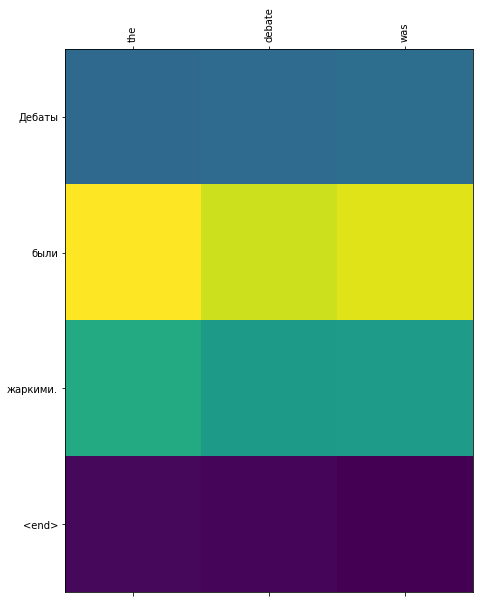

In [ ]:
# request_str = 'Один раз в жизни я делаю хорошее дело... И оно бесполезно.'
# request_str = 'Привет как дела'
# request_str = 'Образование в этом мире меня разочаровывает'
request_str = 'Дебаты были жаркими.'
plot_heatmaps(request_str)

# Additional training. Results on 10 epochs

In [ ]:
enc_seq_len = 69
dec_seq_len = 69

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=RMSprop(lr = 0.001))
model.fit([X_enc, X_dec], Y, epochs=10, callbacks=callback_,  batch_size=80, validation_split=0.2)
model.save('/content/drive/My Drive/tmp/attention_seq2seq.h5' )

Epoch 1/10
815/815 [==============================] - 731s 896ms/step - loss: 1.8819 - accuracy: 0.7830 - val_loss: 2.2802 - val_accuracy: 0.7533
Epoch 2/10
815/815 [==============================] - 730s 895ms/step - loss: 1.7890 - accuracy: 0.7916 - val_loss: 2.2855 - val_accuracy: 0.7528
Epoch 3/10
815/815 [==============================] - 729s 894ms/step - loss: 1.7453 - accuracy: 0.7968 - val_loss: 2.3072 - val_accuracy: 0.7511
Epoch 4/10
815/815 [==============================] - 728s 894ms/step - loss: 1.7110 - accuracy: 0.8011 - val_loss: 2.3376 - val_accuracy: 0.7505
Epoch 5/10
815/815 [==============================] - 728s 894ms/step - loss: 1.6828 - accuracy: 0.8048 - val_loss: 2.3412 - val_accuracy: 0.7498


## Inference

In [ ]:
enc_seq_len = 69
dec_seq_len = 1
# Input
encoder_reshaped = Input((dec_seq_len, enc_seq_len,hidden_dim,))
decoder_state_input_h = Input((hidden_dim,))
decoder_state_input_c = Input((hidden_dim,))
final_st = [decoder_state_input_h, decoder_state_input_c]
decoder_input = Input((dec_seq_len,))

# Decoder
dec_emb = Embedding(num_words, emb_size, name='emb')(decoder_input)
dec_lstm, *states_value = LSTM(hidden_dim, return_state=True, name='dec_lstm')(dec_emb, initial_state = final_st)

# Attention
dec_resh = Reshape((dec_seq_len, hidden_dim))(dec_lstm)
dec_lstm_reshaped = Reshape((dec_seq_len, 1, hidden_dim))(dec_resh)
conc = concatenate([encoder_reshaped, dec_lstm_reshaped], axis=-2)
conc_reshaped = Reshape((dec_seq_len, hidden_dim*(enc_seq_len+1)))(conc)

gates = Dense(enc_seq_len, activation='softmax', name= 'dense_att')(conc_reshaped)
gates_reshaped = Reshape((dec_seq_len, enc_seq_len, 1))(gates)
gates_repeated = Lambda(lambda l: K.repeat_elements(l, hidden_dim, -1))(gates_reshaped)

dot_product = Lambda(lambda xy: K.sum(xy[0]*xy[1], axis=-2))([encoder_reshaped, gates_repeated])

attentive_state = concatenate([dec_resh, dot_product])

# Exit
word_probabilities = Dense(num_words, activation='softmax', name= 'dense')(attentive_state)

# Create models
decoder_model = Model([encoder_reshaped, decoder_input]+final_st, [word_probabilities] + states_value)
encoder_model = Model(encoder_input, [final_states, ys_reshaped])

# Transferring weights
for name in ['emb', 'dec_lstm', 'dense', 'dense_att']:
  decoder_model.get_layer(name=name).set_weights(model.get_layer(name=name).get_weights())

# If the weights were loaded, then the weights of the encoder must also be transferred 
for name in ['enc_emb', 'enc_lstm']:
  encoder_model.get_layer(name=name).set_weights(model.get_layer(name=name).get_weights())


In [ ]:
print('Correctly predicted tokens: ', round(metric(100)*100, 2), '%', sep='')

Correctly predicted tokens: 55.96%


Correctly predicted tokens: 

* Primary training. 5 epochs — 57.36%
* Additional training. +6 epochs — 55.96%

In [ ]:
decode_sequence('какой вкусный пирог')


Answer: the problem is that the eu


In [ ]:
decode_sequence('Ежегодный Всемирный экономический форум по праву воспринимают как глобальный « барометр » .')

Answer: the world ’ s economic forum is based on a “ global economic foru


In [ ]:
for n in range(1, 50, 5):
  print('------', enc_in[n][:-5])
  decode_sequence(enc_in[n])
  print('------', decoder_out[n][:-5])
  print('-'*40)

------ В отчаянном стремлении удержать власть , Первез Мушарраф отверг конституционную систему Пакистана и объявил о введении чрезвычайного положения . 
Answer: otherwise , musharraf has created a good name , and the benefits of musharraf had little authority to get otherw
------ Desperate to hold onto power , Pervez Musharraf has discarded Pakistan ’ s constitutional framework and declared a state of emergency . 
----------------------------------------
------ Многие пакистанцы , лишённые иллюзий в отношении политического класса Пакистана , молчаливо согласились с его приходом к власти , думая , что он сможет что - то изменить . 
Answer: he says that he will become a political class , many of which he will claim that he will be able to impose his power on the age
------ Many Pakistanis , disillusioned with Pakistan ’ s political class , remained mute , thinking that he might deliver . 
----------------------------------------
------ Результаты данных операций против Талибана и Аль - К

In [ ]:
for n in range(100, 150, 5):
  print('------', enc_in[n][:-5])
  decode_sequence(enc_in[n])
  print('------', decoder_out[n][:-5])
  print('-'*40)

------ Несмотря на диктаторский характер режима президент аль Ассад по - прежнему должен удовлетворять общественное настроение в отношении Израиля . 
Answer: despite the nature of the regime , the west must continue to threaten israel ' s popular despite dictators
------ Despite the dictatorial nature of his regime , President al - Assad still needs to satisfy popular sentiment regarding Israel . 
----------------------------------------
------ Колыбель противоречий 
Answer: the great depre
------ Cradle of Contradictions 
----------------------------------------
------ Мирное сосуществование между многочисленными этническими , религиозными и племенными группами в стране - это результат сложного наслоения уступок , компромиссов , негласных соглашений и других прагматических договорённостей , доведённых до совершенства за несколько столетий . 
Answer: the outcome of the country ’ s survival is a powerful outcome , and the outcome of the country ’ s survival is a viable outcome , and the

## Attention matrix

In [ ]:
# Inference with the attention matrix

enc_seq_len = 69
dec_seq_len = 1 

# Input
encoder_reshaped = Input((dec_seq_len, enc_seq_len,hidden_dim,))
decoder_state_input_h = Input((hidden_dim,))
decoder_state_input_c = Input((hidden_dim,))
final_st = [decoder_state_input_h, decoder_state_input_c]
decoder_input = Input((dec_seq_len,))

# Decoder
dec_emb = Embedding(num_words, emb_size, name='emb')(decoder_input)
dec_lstm, *states_value = LSTM(hidden_dim, return_state=True, name='dec_lstm')(dec_emb, initial_state = final_st)

# Attention
dec_resh = Reshape((dec_seq_len, hidden_dim))(dec_lstm)
dec_lstm_reshaped = Reshape((dec_seq_len, 1, hidden_dim))(dec_resh)
conc = concatenate([encoder_reshaped, dec_lstm_reshaped], axis=-2)
conc_reshaped = Reshape((dec_seq_len, hidden_dim*(enc_seq_len+1)))(conc)

# Output with Dense is needed for the attention matrix
gates = Dense(enc_seq_len, activation='softmax', kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001), name= 'dense_att')(conc_reshaped)

gates_reshaped = Reshape((dec_seq_len, enc_seq_len, 1))(gates)
gates_repeated = Lambda(lambda l: K.repeat_elements(l, hidden_dim, -1))(gates_reshaped)

dot_product = Lambda(lambda xy: K.sum(xy[0]*xy[1], axis=-2))([encoder_reshaped, gates_repeated])

attentive_state = concatenate([dec_resh, dot_product])

# Output for inference
word_probabilities = Dense(num_words, activation='softmax', name= 'dense')(attentive_state)

# Creating models
decoder_model_ = Model([encoder_reshaped, decoder_input]+final_st, [word_probabilities, gates] + states_value)
encoder_model_ = Model(encoder_input, [final_states, ys_reshaped])

for name in ['emb', 'dec_lstm', 'dense', 'dense_att']:
  decoder_model_.get_layer(name=name).set_weights(model.get_layer(name=name).get_weights())
for name in ['enc_emb', 'enc_lstm']:
  encoder_model_.get_layer(name=name).set_weights(model.get_layer(name=name).get_weights())

Request:  Дебаты были жаркими.
Answer:   debate


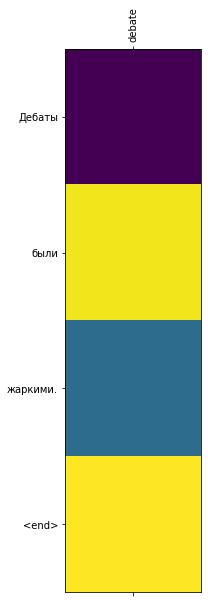

In [ ]:
request_str = 'Дебаты были жаркими.'
plot_heatmaps(request_str)

Request:  Образование в этом мире меня разочаровывает
Answer:   this is why the world health organization has been able to me .


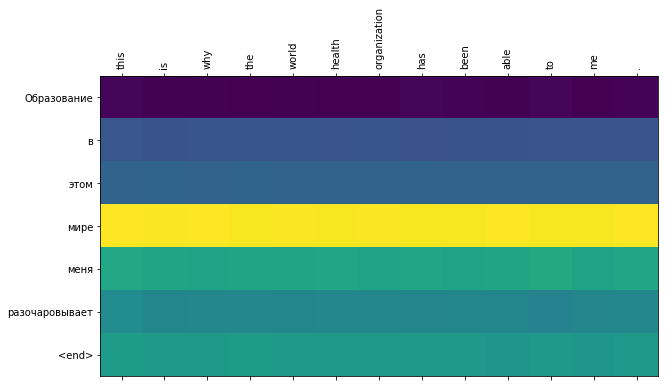

In [ ]:
request_str = 'Образование в этом мире меня разочаровывает'
plot_heatmaps(request_str)

Request:  Привет, как дела?
Answer:   the first is to be seen as a


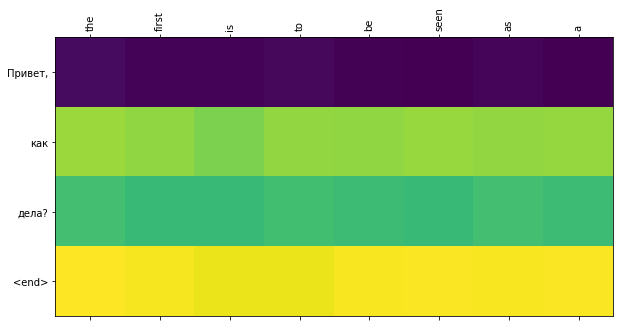

In [ ]:
request_str = 'Привет, как дела?'
plot_heatmaps(request_str)

Request:  Один раз в жизни я делаю хорошее дело... И оно бесполезно.
Answer:   i know that life is getting a life in life and the life expectancy .


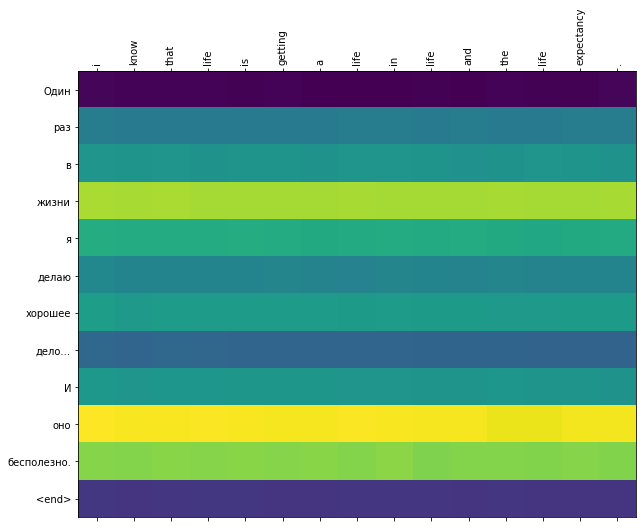

In [ ]:
request_str = 'Один раз в жизни я делаю хорошее дело... И оно бесполезно.'
plot_heatmaps(request_str)

## Conclusions
1. Такое ощущение, что проверка модели после её первичного обучения испортила саму модель, что ухудшило показатели на её дообучении.
2. Переводы вообще нельзя называть таковыми. Хотя правильные единичные термины в "переводных" фразах всё-таки присутствуют.
3. В исходной базе обнаружено большое количество мусора на коротких фразах после обучения. Не известно, оказали ли они отрицательное влияние на процесс обучения из-за предпринятых ранее мер по предотвращению появления мусора в датасете.

